In [80]:
import numpy as np
import pandas as pd
import re
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import arima_model
from statsmodels.graphics.api import qqplot
from scipy import stats

In [3]:

def cleanColumnName(column):
    column = re.sub('\W+',' ', column.strip())                     #Remove all symbols from the column name
    column = column.strip()                                        #Remove all whitespaces from the ends of the column name
    return column.lower().replace(" ","_")                         #Replace spaces in between words with '_'

def dateParse(dates):
    pd.datetime.strptime(dates, '%Y-%m-%d')

def test_stationarity(ticker, timeseries):
    
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=7, center=False).mean()
    rolstd = timeseries.rolling(window=7, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(ticker)
    plt.show(block=False)
    
    #Durbin-Watson Statistic for Autocorrelation
    dftest = durbin_watson(timeseries)
    print(ticker)
    print("Durbin-Watson statistic for "+ticker+": ",dftest)

warnings.filterwarnings('ignore')

In [4]:
bankrupt_companies = pd.read_csv(r"C:\Users\vinee\OneDrive\Desktop\Fulltime\Resume_2020\datasets\public_company_bankruptcy_cases.csv")

In [5]:
bankrupt_companies.head()

,DISTRICT,STATE,COMPANY NAME,ASSETS (MILLIONS),LIABILITIES (MILLIONS)
0,MD,FL,"A21, Inc.",25.2,30.3
1,D,DE,Abitibibowater Inc.,9937.0,2213.0
2,MD,FL,"Accentia Biopharmaceuticals, Inc.",134.9,77.6
3,D,DE,Accredited Home Lenders Holding Co.,799.5,490.7
4,SD,NY,Apex Silver Mines LTD,721.3,930.9


In [7]:
companies_stock_prices = pd.read_csv(r"C:\Users\vinee\OneDrive\Desktop\Fulltime\Resume_2020\datasets\prices-split-adjusted.csv", parse_dates=True, usecols=["date","symbol","close"], date_parser=dateParse)

In [60]:
companies_stock_prices.head()

,date,symbol,close
0,1/5/2016,WLTW,125.839996
1,1/6/2016,WLTW,119.980003
2,1/7/2016,WLTW,114.949997
3,1/8/2016,WLTW,116.620003
4,1/11/2016,WLTW,114.970001


In [9]:
nyse_data = pd.read_csv(r"C:\Users\vinee\OneDrive\Desktop\Fulltime\Resume_2020\datasets\fundamentals.csv", index_col='Unnamed: 0')

In [10]:
nyse_data.head()

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,12/31/2012,3.068000e+09,-222000000,-1961000000,23,-1888000000,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9011000000,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,12/31/2013,4.975000e+09,-93000000,-2723000000,67,-3114000000,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,13806000000,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,12/31/2014,4.668000e+09,-160000000,-150000000,143,-5311000000,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,13404000000,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,12/31/2015,5.102000e+09,352000000,-708000000,135,-6151000000,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,13605000000,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,12/29/2012,2.409453e+09,-89482000,600000,32,-271182000,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2559638000,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [11]:
# DATA CLEANING: Removing unnecessary columns from the datasets. This is completely heuristic, since we
# are dropping the columns based purely on our own understanding of their significance.
bankrupt_companies.drop(["DISTRICT", "STATE", "COMPANY NAME"], axis=1, inplace=True)

In [12]:
nyse_data.drop(["Deferred Asset Charges","Deferred Liability Charges","Depreciation","Earnings Before Tax","Effect of Exchange Rate","Equity Earnings/Loss Unconsolidated Subsidiary","Goodwill","Income Tax","Intangible Assets","Interest Expense","Liabilities","Minority Interest","Misc. Stocks","Net Cash Flow-Operating","Net Cash Flows-Financing","Net Cash Flows-Investing","Net Income Adjustments","Net Income Applicable to Common Shareholders","Net Income-Cont. Operations","Operating Income","Operating Margin","Other Assets","Other Current Assets","Other Current Liabilities","Other Financing Activities","Other Investing Activities","Other Liabilities","Other Operating Activities","Other Operating Items","Pre-Tax Margin","Pre-Tax ROE","Research and Development","Total Current Assets","Total Current Liabilities","Total Liabilities & Equity","Treasury Stock", "For Year"], axis=1, inplace=True)

In [13]:
bankrupt_companies.head()

,ASSETS (MILLIONS),LIABILITIES (MILLIONS)
0,25.2,30.3
1,9937.0,2213.0
2,134.9,77.6
3,799.5,490.7
4,721.3,930.9


In [14]:
nyse_data.head()

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Equity,Total Liabilities,Total Revenue,Earnings Per Share,Estimated Shares Outstanding
0,AAL,12/31/2012,3.068000e+09,-222000000,-1961000000,23,-1888000000,4.695000e+09,53.0,1.330000e+09,...,0,12977000000,1.419000e+09,3.412000e+09,2.351000e+10,-7.987000e+09,2.489100e+10,2.485500e+10,-5.60,3.350000e+08
1,AAL,12/31/2013,4.975000e+09,-93000000,-2723000000,67,-3114000000,1.059200e+10,75.0,2.175000e+09,...,0,12913000000,1.446000e+09,8.111000e+09,4.227800e+10,-2.731000e+09,4.500900e+10,2.674300e+10,-11.25,1.630222e+08
2,AAL,12/31/2014,4.668000e+09,-160000000,-150000000,143,-5311000000,1.513500e+10,60.0,1.768000e+09,...,-1052000000,20686000000,1.677000e+09,6.309000e+09,4.322500e+10,2.021000e+09,4.120400e+10,4.265000e+10,4.02,7.169154e+08
3,AAL,12/31/2015,5.102000e+09,352000000,-708000000,135,-6151000000,1.159100e+10,51.0,1.085000e+09,...,-3846000000,21275000000,2.231000e+09,5.864000e+09,4.841500e+10,5.635000e+09,4.278000e+10,4.099000e+10,11.39,6.681299e+08
4,AAP,12/29/2012,2.409453e+09,-89482000,600000,32,-271182000,5.202150e+08,23.0,5.981110e+08,...,-18600000,2440721000,6.270000e+05,0.000000e+00,4.613814e+09,1.210694e+09,3.403120e+09,6.205003e+09,5.29,7.328355e+07


In [15]:
# DATA CLEANING: Making Column Name Formats Consistent
bankrupt_companies.columns = map(cleanColumnName, bankrupt_companies.columns)

In [17]:
bankrupt_companies.columns = ["total_assets", "total_liabilities"]

In [18]:
companies_stock_prices.columns = map(cleanColumnName, companies_stock_prices.columns)
nyse_data.columns = map(cleanColumnName, nyse_data.columns)

nyse_data.head()

,ticker_symbol,period_ending,accounts_payable,accounts_receivable,add_l_income_expense_items,after_tax_roe,capital_expenditures,capital_surplus,cash_ratio,cash_and_cash_equivalents,...,sale_and_purchase_of_stock,sales_general_and_admin,short_term_debt_current_portion_of_long_term_debt,short_term_investments,total_assets,total_equity,total_liabilities,total_revenue,earnings_per_share,estimated_shares_outstanding
0,AAL,12/31/2012,3.068000e+09,-222000000,-1961000000,23,-1888000000,4.695000e+09,53.0,1.330000e+09,...,0,12977000000,1.419000e+09,3.412000e+09,2.351000e+10,-7.987000e+09,2.489100e+10,2.485500e+10,-5.60,3.350000e+08
1,AAL,12/31/2013,4.975000e+09,-93000000,-2723000000,67,-3114000000,1.059200e+10,75.0,2.175000e+09,...,0,12913000000,1.446000e+09,8.111000e+09,4.227800e+10,-2.731000e+09,4.500900e+10,2.674300e+10,-11.25,1.630222e+08
2,AAL,12/31/2014,4.668000e+09,-160000000,-150000000,143,-5311000000,1.513500e+10,60.0,1.768000e+09,...,-1052000000,20686000000,1.677000e+09,6.309000e+09,4.322500e+10,2.021000e+09,4.120400e+10,4.265000e+10,4.02,7.169154e+08
3,AAL,12/31/2015,5.102000e+09,352000000,-708000000,135,-6151000000,1.159100e+10,51.0,1.085000e+09,...,-3846000000,21275000000,2.231000e+09,5.864000e+09,4.841500e+10,5.635000e+09,4.278000e+10,4.099000e+10,11.39,6.681299e+08
4,AAP,12/29/2012,2.409453e+09,-89482000,600000,32,-271182000,5.202150e+08,23.0,5.981110e+08,...,-18600000,2440721000,6.270000e+05,0.000000e+00,4.613814e+09,1.210694e+09,3.403120e+09,6.205003e+09,5.29,7.328355e+07


In [19]:
# Remove NaN values from respective datasets
bankrupt_companies.dropna(axis=0, subset=['total_assets', 'total_liabilities'], inplace=True)

nyse_data.dropna(axis=1, how='any', inplace=True)
nyse_data.dropna(axis=0, how='any', inplace=True)

companies_stock_prices.dropna(axis=0, how='any', inplace=True)

In [20]:
nyse_data.columns

Index(['ticker_symbol', 'period_ending', 'accounts_payable',
       'accounts_receivable', 'add_l_income_expense_items', 'after_tax_roe',
       'capital_expenditures', 'capital_surplus', 'cash_and_cash_equivalents',
       'changes_in_inventories', 'common_stocks', 'cost_of_revenue',
       'earnings_before_interest_and_tax', 'fixed_assets', 'gross_margin',
       'gross_profit', 'inventory', 'investments', 'long_term_debt',
       'long_term_investments', 'net_borrowings', 'net_cash_flow',
       'net_income', 'net_receivables', 'non_recurring_items', 'other_equity',
       'profit_margin', 'retained_earnings', 'sale_and_purchase_of_stock',
       'sales_general_and_admin',
       'short_term_debt_current_portion_of_long_term_debt',
       'short_term_investments', 'total_assets', 'total_equity',
       'total_liabilities', 'total_revenue'],
      dtype='object')

In [27]:

# Create new dataframe containing data of non-bankrupt companies in 2013
nyse_2013 = nyse_data.loc[nyse_data['period_ending'].str.contains("2013"), ["total_assets", "total_liabilities"]]
#nyse_2013

In [32]:
# Randomly sample this dataset to get a dataframe containing the data for as many non-bankrupt companies 
# as there are bankrupt companies in the other dataset
nyse_2013 = nyse_2013.sample(n=bankrupt_companies.shape[0], replace=False)
#nyse_2013

In [34]:
# Assign indexes to the 2013 NYSE dataframe to start after the last index of the bankrupt_companies 
# dataframe to ease the merge operation
nyse_2013.set_index([[x for x in range(bankrupt_companies.index[-1]+1, bankrupt_companies.index[-1]+nyse_2013.shape[0]+1)]], inplace=True)
#nyse_2013

In [35]:
# Manually adding the column "bankrupt" to the dataset to be used as label 
bankrupt_companies["stability"] = 0
nyse_2013["stability"] = 1

In [38]:
# Merge the bankruptcy and non-bankruptcy dataframes to generate one that can be used for training a classifier.
merged_bankruptcy_dataset = pd.concat([bankrupt_companies, nyse_2013])

In [40]:
# Scaling the data to ensure assets and liabilities are in equivalent ranges
scaler = pp.MinMaxScaler()
scaler.fit(merged_bankruptcy_dataset[["total_assets", "total_liabilities"]])
merged_bankruptcy_dataset[["total_assets", "total_liabilities"]] = scaler.transform(merged_bankruptcy_dataset[["total_assets", "total_liabilities"]])

In [42]:
# Randomly Splitting the merged dataset into training and test datasets for training the Decision Tree
train_bankruptcy_data, test_bankruptcy_data, train_bankruptcy_target, test_bankruptcy_target = train_test_split(
    merged_bankruptcy_dataset.iloc[:,0:-1], merged_bankruptcy_dataset.iloc[:,-1], 
    test_size=0.25
)

(190, 2) 0.6894736842105263
(64, 2) 0.546875


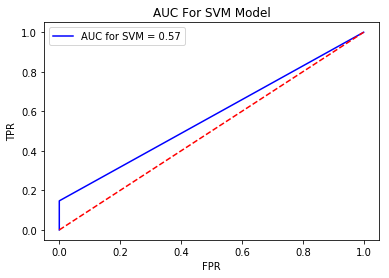

In [43]:
#Training SVM on the training data
Svm_model = svm.LinearSVC()
Svm_model.fit(train_bankruptcy_data, train_bankruptcy_target)

print(train_bankruptcy_data.shape, Svm_model.score(train_bankruptcy_data, train_bankruptcy_target))
print(test_bankruptcy_data.shape, Svm_model.score(test_bankruptcy_data, test_bankruptcy_target))

# Calculating and plotting the ROC and Area-under-curve to understand the classifier accuracy
FPR, TPR, _ = metrics.roc_curve(test_bankruptcy_target, Svm_model.predict(test_bankruptcy_data))
auc = metrics.auc(FPR, TPR)

plt.plot(FPR, TPR, 'b', label = 'AUC for SVM = %0.2f' %auc)
plt.title("AUC For SVM Model")
plt.legend(loc='best')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

In [44]:
FPR, TPR, _ = metrics.roc_curve(test_bankruptcy_target, Svm_model.predict(test_bankruptcy_data))

In [45]:
FPR

array([0., 0., 1.])

In [46]:
TPR

array([0.        , 0.14705882, 1.        ])

In [47]:
_

array([2, 1, 0], dtype=int64)

In [52]:
metrics.accuracy_score(test_bankruptcy_target, Svm_model.predict(test_bankruptcy_data))

0.546875

In [53]:
metrics.confusion_matrix(test_bankruptcy_target, Svm_model.predict(test_bankruptcy_data))

array([[30,  0],
       [29,  5]], dtype=int64)

In [54]:
metrics.f1_score(test_bankruptcy_target, Svm_model.predict(test_bankruptcy_data))

0.25641025641025644

In [55]:

# Keep only the data for the last year for all companies. We shall be taking only latest data into consideration.
nyse_data.drop_duplicates(subset='ticker_symbol', keep='last', inplace=True)

# Adding in the predicted values for bankruptcy in the original dataset
nyse_data["stability"] = Svm_model.predict(scaler.transform(nyse_data[["total_assets", "total_liabilities"]]))
print("Companies predicted to go bankrupt over a 4 year period: ", len(nyse_data.loc[nyse_data["stability"] != 1, "ticker_symbol"]))

Companies predicted to go bankrupt over a 4 year period:  304


In [66]:
#Time Series Analysis
companies_stock_prices["date"] = pd.to_datetime(companies_stock_prices["date"])

In [70]:
companies_stock_prices.dropna(axis=0, how='any', inplace=True)

In [73]:
# Sorting by ticker symbol
companies_stock_prices.sort_values(by=["symbol", "date"], inplace=True)

In [74]:
# Assuming that the stock trend for each company is distinct, we shall need to model different
# time series for each company by storing the data for each in separate keys in a dictionary.
weekly_stock_prices = {}            # Dictionary to store weekly stock prices for each company

# Add data for each company into separate keys in the dictionary so that time series analysis
# can be run separately for each company.
for i in np.unique(companies_stock_prices["symbol"].values):
    weekly_stock_prices[i] = companies_stock_prices.loc[companies_stock_prices["symbol"] == i, :].copy()
    weekly_stock_prices[i] = weekly_stock_prices[i].reset_index(drop=True)

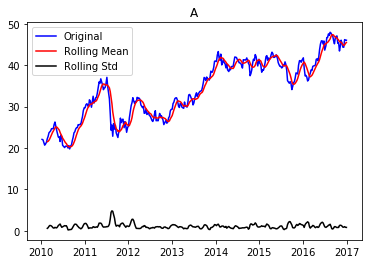

A
Durbin-Watson statistic for A:  [0.00082012]


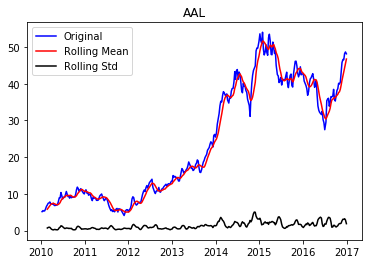

AAL
Durbin-Watson statistic for AAL:  [0.00212219]


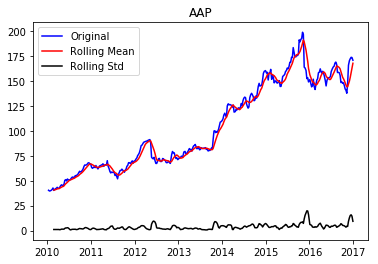

AAP
Durbin-Watson statistic for AAP:  [0.0010451]


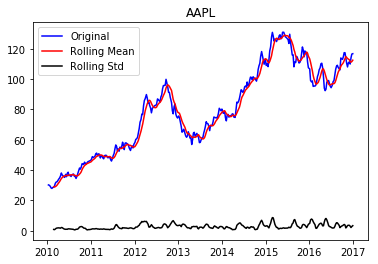

AAPL
Durbin-Watson statistic for AAPL:  [0.00082069]


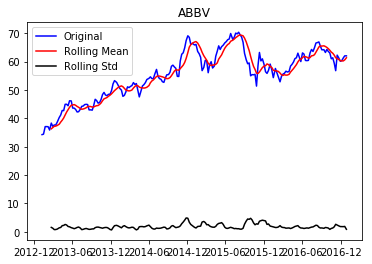

ABBV
Durbin-Watson statistic for ABBV:  [0.00093193]


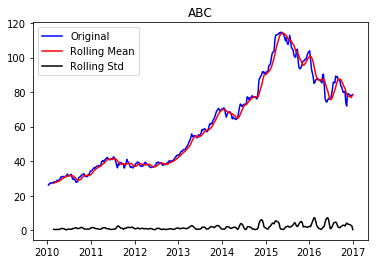

ABC
Durbin-Watson statistic for ABC:  [0.00060559]


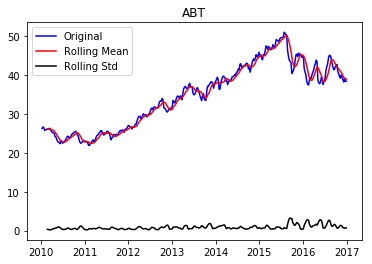

ABT
Durbin-Watson statistic for ABT:  [0.00046642]


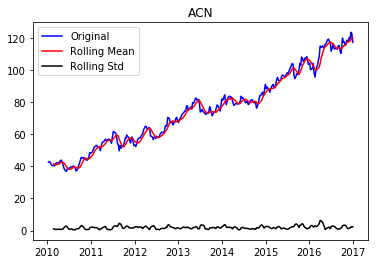

ACN
Durbin-Watson statistic for ACN:  [0.00054152]


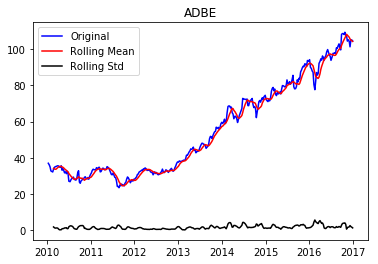

ADBE
Durbin-Watson statistic for ADBE:  [0.00074189]


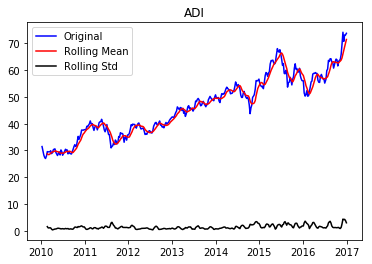

ADI
Durbin-Watson statistic for ADI:  [0.00073023]


In [75]:
count = 0
for i in weekly_stock_prices:
    weekly_mean = weekly_stock_prices[i]["close"].rolling(window=5, center=False).mean()[4:]
    # Convert the daily stock data to weekly by keeping only the data for one day a week
    weekly_stock_prices[i] = weekly_stock_prices[i].loc[weekly_stock_prices[i].index % 5 == 0, :]
    weekly_stock_prices[i]["close"] = weekly_mean
    weekly_stock_prices[i].index = weekly_stock_prices[i]["date"]
    weekly_stock_prices[i].drop(["symbol", "date"], axis=1, inplace=True)
    weekly_stock_prices[i].dropna(axis=0, how='any', inplace=True)
    
    count += 1
    # Showing only the first 10 plots since there are ~450 companies, and plotting them all would
    # take a lot of time. Trend and seasonality can be assumed to be present in all of them.
    if count <= 10:
        test_stationarity(i, weekly_stock_prices[i])

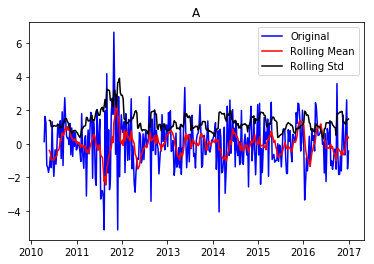

A
Durbin-Watson statistic for A:  1.877026806362659


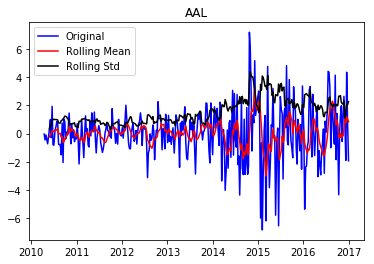

AAL
Durbin-Watson statistic for AAL:  1.6537317417868205


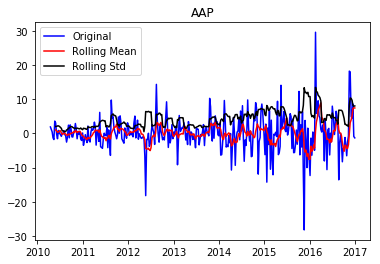

AAP
Durbin-Watson statistic for AAP:  1.6198291714072184


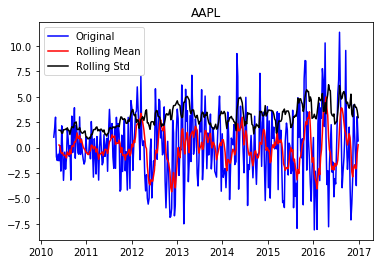

AAPL
Durbin-Watson statistic for AAPL:  1.4553815902174676


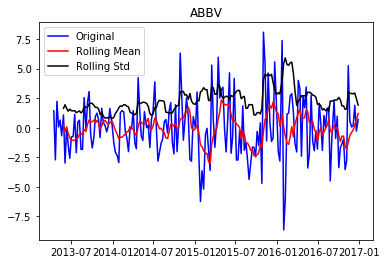

ABBV
Durbin-Watson statistic for ABBV:  1.8224304701510499


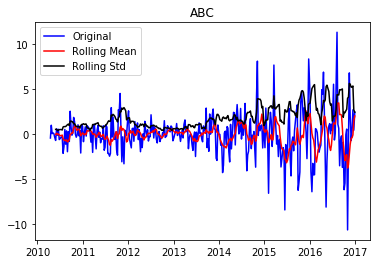

ABC
Durbin-Watson statistic for ABC:  1.3236146242469047


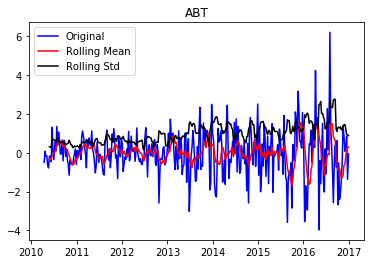

ABT
Durbin-Watson statistic for ABT:  1.4996659516777877


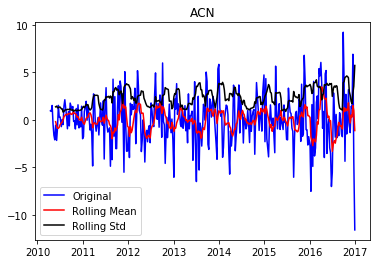

ACN
Durbin-Watson statistic for ACN:  1.7232374331031954


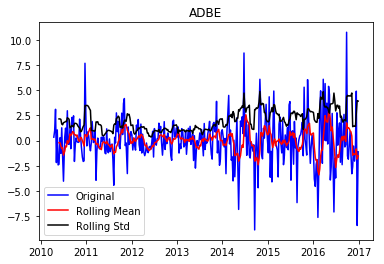

ADBE
Durbin-Watson statistic for ADBE:  1.8407997273561738


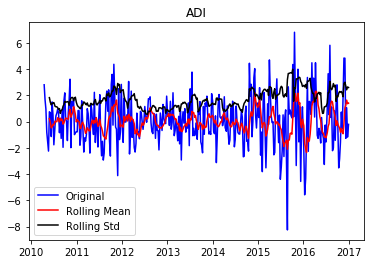

ADI
Durbin-Watson statistic for ADI:  1.680963580821613


In [76]:
# Making the data stationary

count = 0
weekly_stock_prices_log = {}
for i in weekly_stock_prices:
    # Using Differencing to remove Trend and Seasonality in the data
    weekly_stock_prices_log[i] = weekly_stock_prices[i].copy()
    weekly_stock_prices_log[i]["first_difference"] = weekly_stock_prices_log[i]["close"] - weekly_stock_prices_log[i]["close"].shift(1)
    weekly_stock_prices_log[i]["seasonal_first_difference"] = weekly_stock_prices_log[i]["first_difference"] - weekly_stock_prices_log[i]["first_difference"].shift(12)

    count += 1
    if count <=10:
        test_stationarity(i, weekly_stock_prices_log[i]["seasonal_first_difference"].dropna(inplace=False))

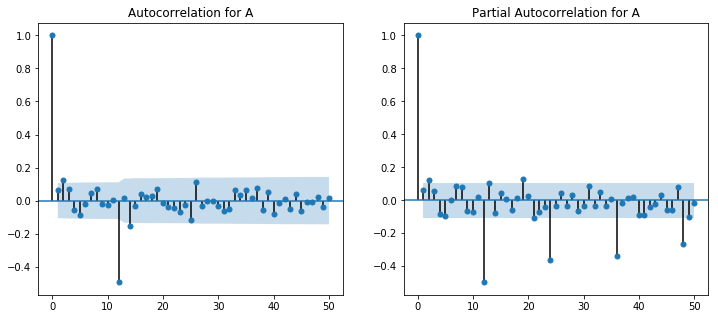

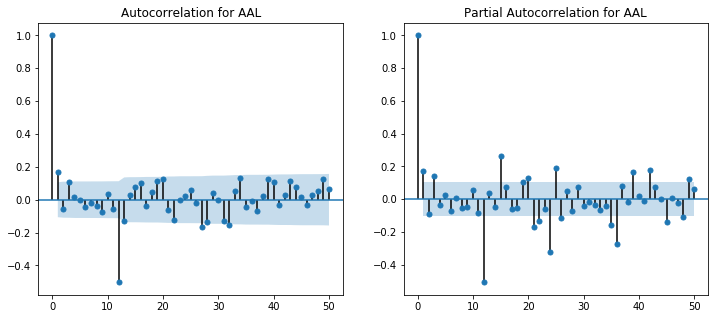

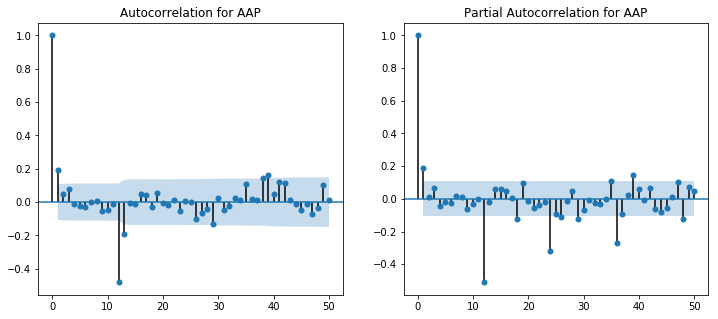

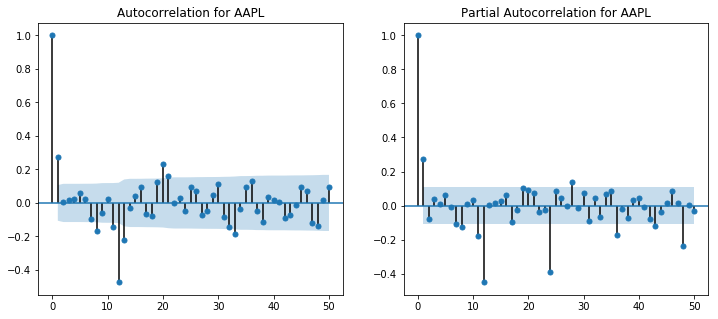

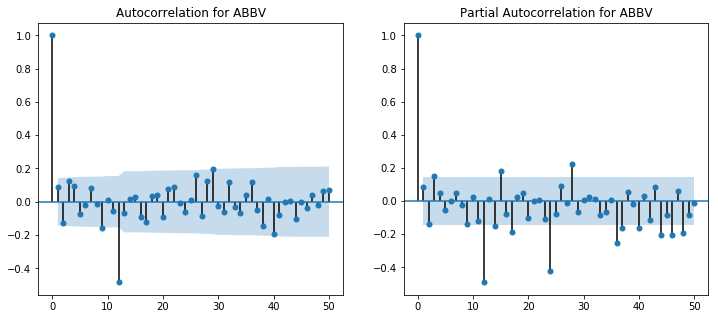

In [77]:
# Decide the Autoregression and Moving Average Parameters by plotting ACF and PACF plots.
count = 0
for i in weekly_stock_prices_log:
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)
    plot_acf(weekly_stock_prices_log[i]["seasonal_first_difference"].iloc[13:], lags=50, title="Autocorrelation for "+i, ax=ax1)
    ax2 = fig.add_subplot(122)
    plot_pacf(weekly_stock_prices_log[i]["seasonal_first_difference"].iloc[13:], lags=50, title="Partial Autocorrelation for "+i, ax=ax2)
    count += 1
    if count == 5:
        break
plt.show()

For A:  NormaltestResult(statistic=285.36621433375797, pvalue=1.0802241854898656e-62)


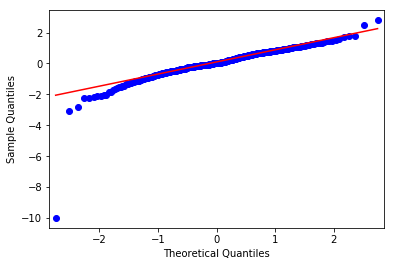

For AAL:  NormaltestResult(statistic=289.0432193323888, pvalue=1.7181552607311996e-63)


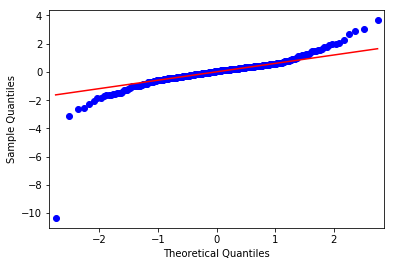

For AAP:  NormaltestResult(statistic=489.1276354884618, pvalue=6.127502265409764e-107)


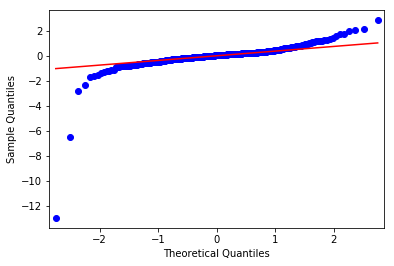

For AAPL:  NormaltestResult(statistic=457.81074972266276, pvalue=3.869535360986819e-100)


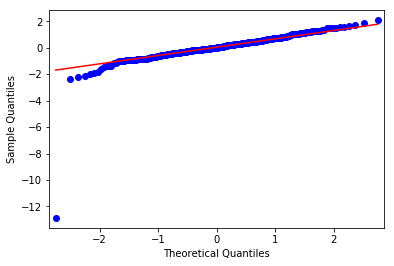

For ABBV:  NormaltestResult(statistic=174.32599124840038, pvalue=1.3982730081888845e-38)


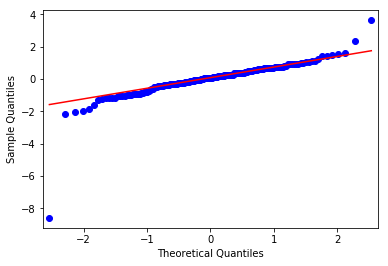

In [81]:
count = 0
stock_predictions = {}
for i in weekly_stock_prices_log:
    # Splitting available data into training for accuracy check using remaining data points
    split_point = len(weekly_stock_prices_log[i]) - 20
    # Number of weeks from last date in dataset to 2018-12-31 = 117
    num_of_predictions = len(weekly_stock_prices_log[i]) + 117
    training = weekly_stock_prices_log[i][0:split_point]
    model = {}
    # Try modelling first using p=2, q=1, if that fails use p=1, q=0
    try:
        model = arima_model.ARMA(training["close"], order=(2,1)).fit()
    except:
        model = arima_model.ARMA(training["close"], order=(1,0)).fit()
    
    #Add the predicted values in a dataframe for ease of further operations.
    daterange = pd.date_range(training.index[0], periods=num_of_predictions, freq = 'W-MON').tolist()
    stock_predictions[i] = pd.DataFrame(columns=["date", "prediction"])
    stock_predictions[i]["date"] = daterange
    stock_predictions[i]["prediction"] = model.predict(start=0, end=num_of_predictions)
    stock_predictions[i].set_index("date", inplace=True)
    
    # Draw a QQPlot to check if the residuals are evenly distributed
    if count < 5:
        resid = model.resid
        print("For "+i+": ",stats.normaltest(resid))
        qqplot(resid, line='q', fit=True)
        plt.show()
        count += 1

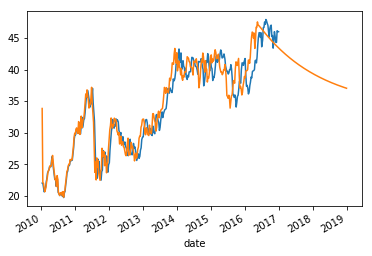

'Mean Absolute Error for A: 0.047314151762794125'

'Mean Forecast Error for A: 2.1729930136632447'

-------------------------------------------------------------------------------------------------------------------------


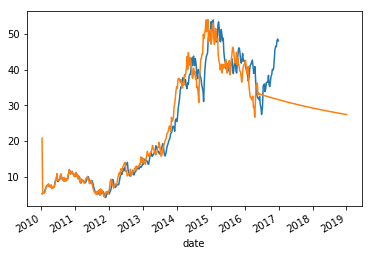

'Mean Absolute Error for AAL: 0.10250354604221465'

'Mean Forecast Error for AAL: 3.359402373110484'

-------------------------------------------------------------------------------------------------------------------------


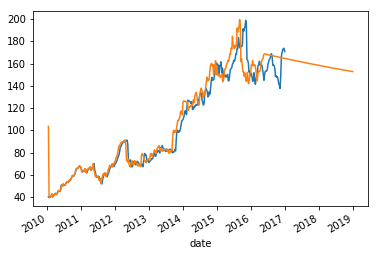

'Mean Absolute Error for AAP: 0.03447508305408851'

'Mean Forecast Error for AAP: -5.774582661699365'

-------------------------------------------------------------------------------------------------------------------------


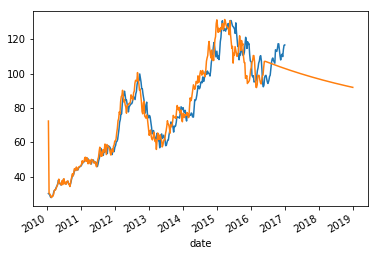

'Mean Absolute Error for AAPL: 0.02739320416270031'

'Mean Forecast Error for AAPL: 2.903385153124603'

-------------------------------------------------------------------------------------------------------------------------


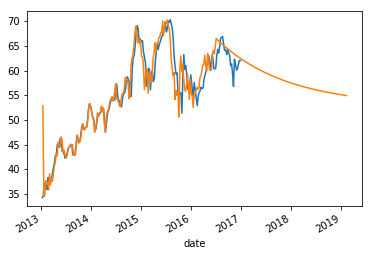

'Mean Absolute Error for ABBV: 0.03227783239480643'

'Mean Forecast Error for ABBV: -2.093190649884486'

-------------------------------------------------------------------------------------------------------------------------


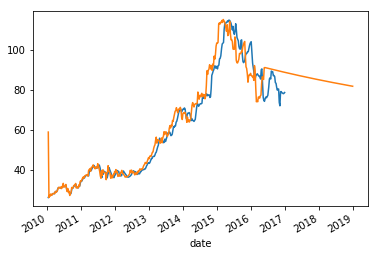

'Mean Absolute Error for ABC: 0.020288688889794747'

'Mean Forecast Error for ABC: -1.8330319175849372'

-------------------------------------------------------------------------------------------------------------------------


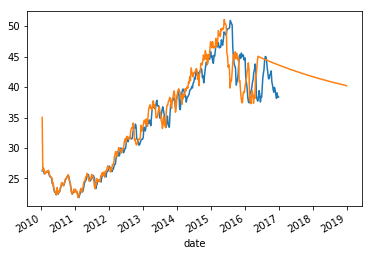

'Mean Absolute Error for ABT: 0.004415613714188542'

'Mean Forecast Error for ABT: -0.19694594242851812'

-------------------------------------------------------------------------------------------------------------------------


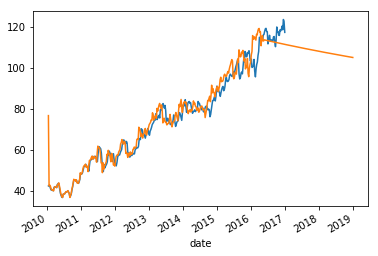

'Mean Absolute Error for ACN: 0.00918144811795001'

'Mean Forecast Error for ACN: 1.0371762206443453'

-------------------------------------------------------------------------------------------------------------------------


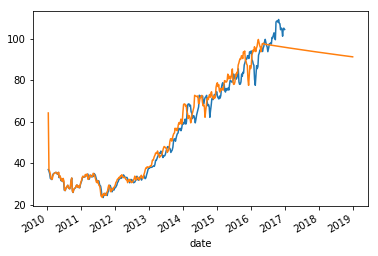

'Mean Absolute Error for ADBE: 0.04217847252076845'

'Mean Forecast Error for ADBE: 4.08914641204197'

-------------------------------------------------------------------------------------------------------------------------


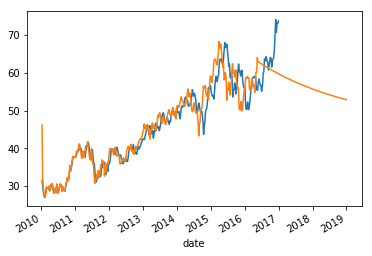

'Mean Absolute Error for ADI: 0.0364009856200826'

'Mean Forecast Error for ADI: 2.2551313518928446'

-------------------------------------------------------------------------------------------------------------------------


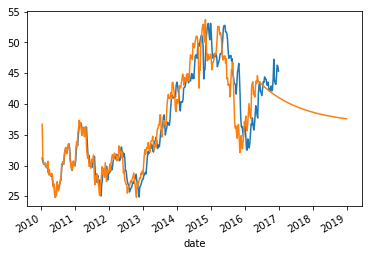

'Mean Absolute Error for ADM: 0.0254795408555951'

'Mean Forecast Error for ADM: 1.0910207318564886'

-------------------------------------------------------------------------------------------------------------------------


In [83]:
# Analysis of the Time Series model
count = 0
for i in weekly_stock_prices_log:
    # Plot actual values against predicted values
    weekly_stock_prices_log[i]["close"].plot()
    stock_predictions[i]["prediction"].plot()
    plt.show()
    
    # Calculate Mean Absolute Error and Mean Forecast Error for Validation data points
    split_point = len(weekly_stock_prices_log[i]) - 20
    forecastedValues = stock_predictions[i]["prediction"].iloc[split_point : len(weekly_stock_prices_log[i])]
    actualValues = weekly_stock_prices_log[i]["close"].iloc[split_point:]
    mfe = actualValues.subtract(forecastedValues).mean()
    mae = (abs(mfe)/forecastedValues).mean()
    display("Mean Absolute Error for "+i+": "+str(mae))
    display("Mean Forecast Error for "+i+": "+str(mfe))
    print("-------------------------------------------------------------------------------------------------------------------------")
    count += 1
    if count > 10:
        break

In [93]:
nyse_data1 = pd.read_csv(r"C:\Users\vinee\OneDrive\Desktop\Fulltime\Resume_2020\datasets\fundamentals.csv", index_col='Unnamed: 0')

In [95]:
nyse_data['ticker_symbol'] = nyse_data1['Ticker Symbol']

In [97]:

# Create new column to store the predicted stock prices
nyse_data["stock_pred"] = np.nan
for i in stock_predictions:
    # Calculating a percentage metric to estimate the rise or fall of the company's stock -- and
    # consequently the organization's growth -- in order to maintain a fair range across all organizations.
    perc=(stock_predictions[i]["prediction"].tail(105).mean() - stock_predictions[i]["prediction"].tail(105)[0])/stock_predictions[i]["prediction"].tail(105)[0]
    nyse_data.loc[nyse_data["ticker_symbol"] == i, "stock_pred"] = perc

# Add the predicted value of bankruptcy to the predicted stock price to generate a compounded
# label that effectively represents the growth or degeneration of the company.
#nyse_data["stock_pred"] += nyse_data["stability"]

# # Drop unnecessary and non-numerical columns from dataset for ease of modelling.
# nyse_data.drop(["period_ending", "stability", "ticker_symbol"], axis=1, inplace=True)
# nyse_data.dropna(axis=0, subset=["stock_pred"], inplace=True)

In [102]:
# Scale the Features of the dataset
nyse_data_scaled = nyse_data.iloc[:,0:-1]
scaler = pp.StandardScaler()
nyse_data_scaled[nyse_data_scaled.columns] = scaler.fit_transform(nyse_data_scaled[nyse_data_scaled.columns])

# Scale the target variable to lie in between the values -1 and 1, rounded up to the nearest tenth place
# and multiplied by 10 to generate a non-continuous multi-valued label.
scaler = pp.MinMaxScaler(feature_range=(-1,1))
nyse_data_target_scaled = scaler.fit_transform(nyse_data.iloc[:,-1].reshape(-1,1)).round(decimals=1) * 10

# Split the augmented dataset into train and test sets for training the classifier.
train_data, test_data, train_target, test_target = train_test_split(nyse_data_scaled, nyse_data_target_scaled, test_size=0.25)

In [103]:
# Training a Random Forest Classifier
RF = RandomForestClassifier()
RF.fit(train_data, train_target)

model_predictions = RF.predict(test_data)

print("Training:-->",train_data.shape, RF.score(train_data, train_target))
print("Testing:-->",test_data.shape, RF.score(test_data, test_target))

Training:--> (335, 34) 0.9761194029850746
Testing:--> (112, 34) 0.3482142857142857


In [104]:
# Analyze the features found by the Random Forest model to correlate most highly
# with the augmented label. Observe the numeric correlation.
top_features = np.argsort(RF.feature_importances_[-5:])
top_features = np.append(top_features, -1)
display(nyse_data.iloc[:, top_features].corr())

,accounts_payable,after_tax_roe,add_l_income_expense_items,accounts_receivable,capital_expenditures,stock_pred
accounts_payable,1.000000,0.004477,0.108513,0.497647,-0.272388,-0.038895
after_tax_roe,0.004477,1.000000,-0.007567,0.001118,-0.012202,0.160753
add_l_income_expense_items,0.108513,-0.007567,1.000000,0.029673,-0.354544,0.017996
accounts_receivable,0.497647,0.001118,0.029673,1.000000,-0.055568,0.040277
capital_expenditures,-0.272388,-0.012202,-0.354544,-0.055568,1.000000,-0.102515
stock_pred,-0.038895,0.160753,0.017996,0.040277,-0.102515,1.000000


In [105]:
# Generate a Confusion Matrix and calculate the Matthews Correlation co-efficienct as
# evaluation metrics for the Random Forest classifier that was trained.
display("CONFUSION MATRIX: ",metrics.confusion_matrix(test_target, model_predictions))
display("MATTHEWS CORRELATION CO-EFFICIENT", metrics.matthews_corrcoef(test_target, model_predictions))

'CONFUSION MATRIX: '

array([[ 0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  2, 10,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6, 27,  6,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  4, 11, 10,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  6,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  3,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

'MATTHEWS CORRELATION CO-EFFICIENT'

0.10271578750009698